## Tournament Analysis

Chris Hua // chua@wharton.upenn.edu

In [81]:
import random

from itertools import zip_longest

import networkx as nx

import numpy as np

import pandas as pd

import seaborn as sns

import tournament

from pandas_ply import install_ply, X, sym_call

install_ply(pd)

%matplotlib inline

%config InlineBackend.figure_format='retina'


We present some functions to do the tournament analysis. 

These functions above are used to simulate the tournament functions. Below we present a function to run a tournament for one iteration.

We further define some helper functions. In particular, `simulate_tournament` runs tournaments for a given number of iterations. With a seed set, these will run tournaments with *the same teams* - i.e. the only thing that changes is who wins each round, by the different random number draws.

Here we show the usage of the tournament simulator.

In [83]:
res = simulate_tournament(48, 6, seed = 20, n_simul = 100)

Here we show usage of the output data. We aggregate the data, by each team, and average out the wins per tournament. In particular, we define "break" here as wining 4 or more rounds out of 6 in a tournament. This is a crude mechanism for being noted as "top-k" - typically in 6 round tournaments, getting 4 wins is necessary but not sufficient to advance. 

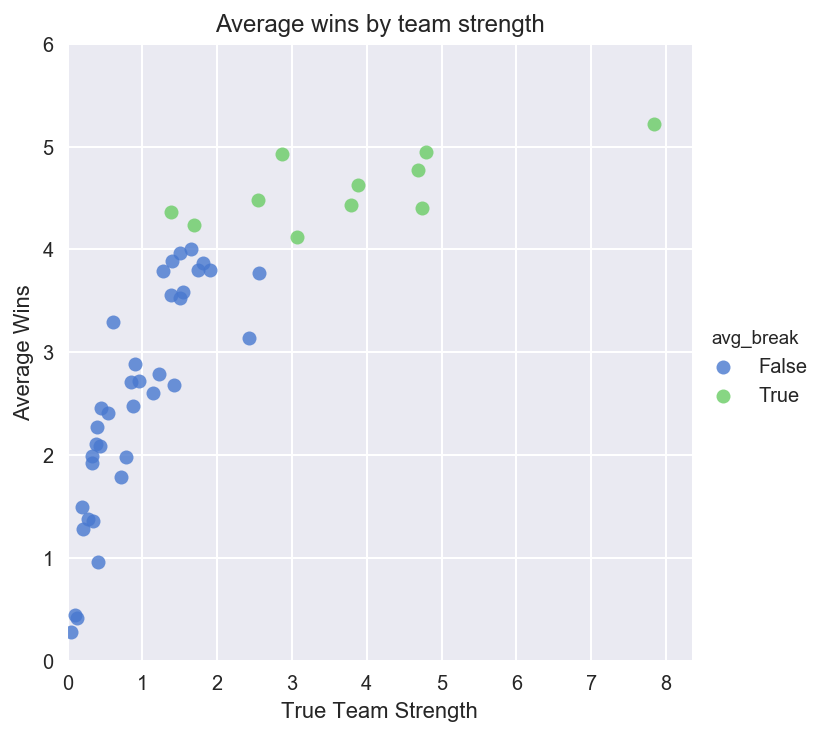

In [89]:
res_summ = (res
    .groupby('strength')
    .ply_select(
        strength = X.strength.mean(),
        avg_wins = X.wins.mean(),
        avg_break = X.wins.mean() > 4
    ))
#res_summ
lm = sns.lmplot(x = "strength", y = "avg_wins",
                hue = "avg_break",
                data = res_summ, palette="muted",
                fit_reg = False)
axes = lm.axes
axes[0,0].set_ylim(0,6)
axes[0,0].set_xlim(0,)
sns.plt.title("Average wins by team strength")
lm.set_xlabels("True Team Strength")
lm.set_ylabels("Average Wins")

In this case, how many teams got 4 wins?

2 - finals
4 - semifinals
8 - quarterfinals
16 - octofinals.

In general, this looks to be pretty close - a medium sized tournament with 48 teams should be breaking to quarterfinals, i.e. taking about 8 teams. This is a bit of a contrived example, since tournaments are usually smaller or larger, but is a useful gut check.

In [84]:
res_summ.groupby('avg_break').count()

,avg_wins,strength
avg_break,,
False,35,35
True,13,13


We can also consider this in terms of 

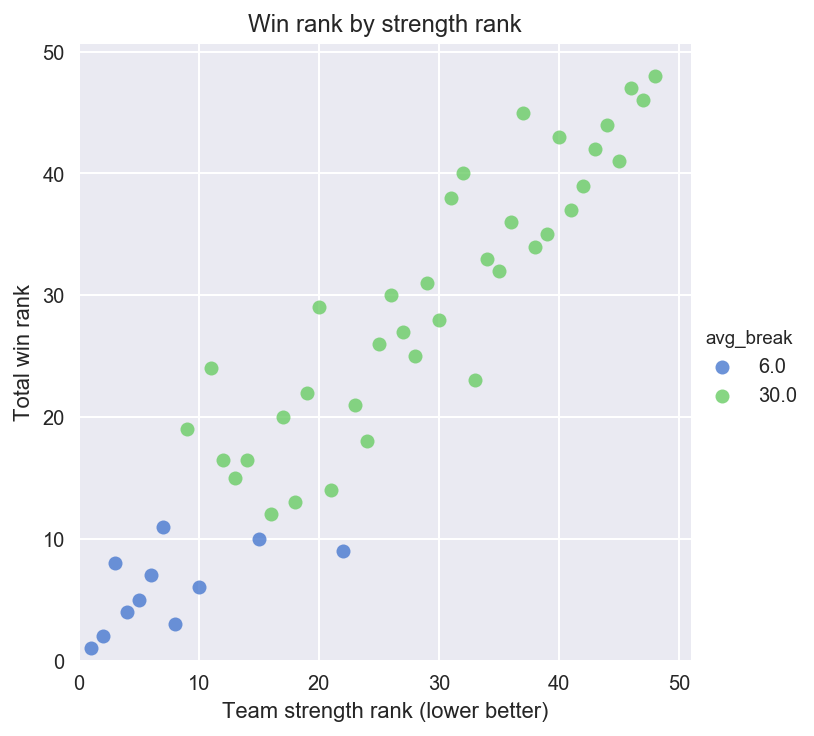

In [90]:
res_rank = res_summ.rank(ascending = False)
lm3 = sns.lmplot(x = "strength", y = "avg_wins",
                hue = "avg_break",
                data = res_rank, palette="muted",
                fit_reg = False)
axes3 = lm3.axes
axes3[0,0].set_ylim(0,)
axes3[0,0].set_xlim(0,)
sns.plt.title("Win rank by strength rank")
lm3.set_xlabels("Team strength rank (lower better)")
lm3.set_ylabels("Total win rank")

Finally, we show the actual answer which we are interested in finding. We plot the percent of rounds in which a team got 4 or more wins; that is, a proxy for being a top-$k$ team.

The expectations line up with what we would typically expect, as the top eight teams are all each in the top eight above 80% of the time. However, even weak teams can break ~40% of the time, which is relatively surprising.

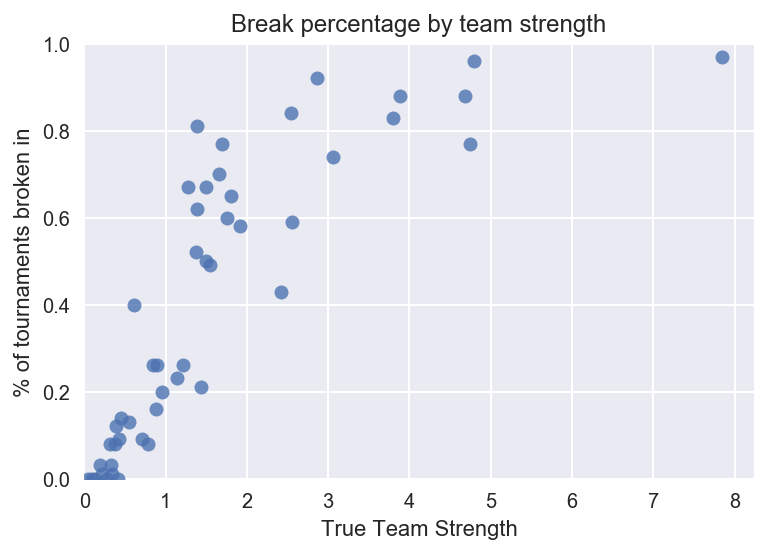

In [91]:
res_breaks = (res
    .groupby('strength')['wins']
    .agg({'n_break': lambda x : (x >= 4).mean()})
)
res_breaks.index.name = 'strength'
res_breaks.reset_index(inplace=True)

lm2 = sns.regplot(x = "strength", y = "n_break",
               data = res_breaks, fit_reg = False)
axes2 = lm2.axes
axes2.set_ylim(0,1)
axes2.set_xlim(0,)
sns.plt.title("Break percentage by team strength")
lm2.set_xlabel("True Team Strength")
lm2.set_ylabel("% of tournaments broken in")

To see what the true effect should be is, we can run tournaments using the same teams but with more rounds. With more rounds, we would expect the true nature of the data to show more.


The break percentages are more limited here. With more rounds, it is harder for a weak team to break.

In [87]:
res2 = simulate_tournament(48, 9, seed = 20, n_simul = 100)

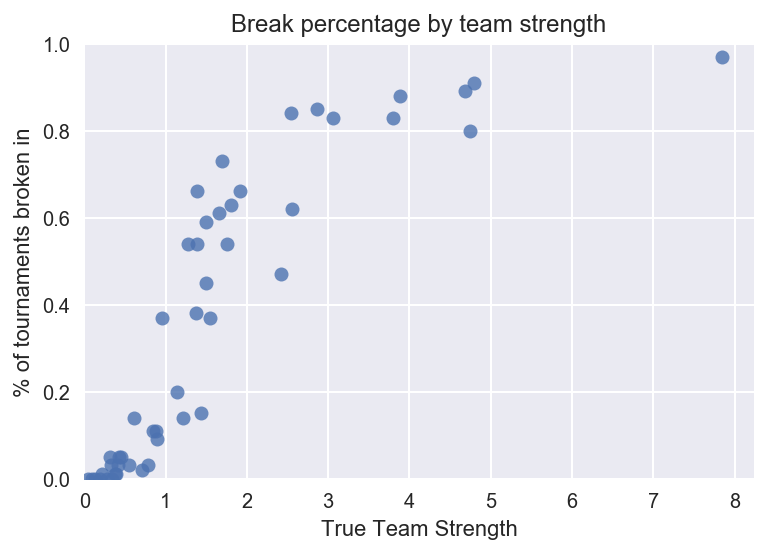

In [92]:
res_breaks2 = (res2
    .groupby('strength')['wins']
    .agg({'n_break': lambda x : (x >= 6).mean()})
)
res_breaks2.index.name = 'strength'
res_breaks2.reset_index(inplace=True)

lm3 = sns.regplot(x = "strength", y = "n_break",
               data = res_breaks2, fit_reg = False)
axes3 = lm3.axes
axes3.set_ylim(0,1)
axes3.set_xlim(0,)
sns.plt.title("Break percentage by team strength")
lm3.set_xlabel("True Team Strength")
lm3.set_ylabel("% of tournaments broken in")

## Model strength distribution

Above we use a log-normal distribution to model the team strength, which is a good first guess at the distribution of team strength. It fits the intuition that there are a few extraordinarily strong teams and many average ones. However, the choice of distribution as well as dispersion parameter has a very large effect on what the win rates look like. Here, we discuss these effects, and fit the model to real world data.